In [1]:
import numpy as np
import pandas as pd
import pycm
import random
from scipy.stats import mode
import pprint as pp
import itertools
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/moons_data.csv")

In [3]:
data = pd.read_csv("../data/blobs_data.csv")

In [4]:
data = pd.read_csv("../data/circles_data.csv")

In [5]:
data.head()

,x1,x2,y
0,0.751550,0.022892,1
1,0.627924,0.821509,0
2,-0.085756,-1.035764,0
3,0.894887,-0.446699,0
4,0.820796,-0.191317,1


In [253]:
class decisionTree():
    """This is an objec that will store
    all the information needed to create
    a decision tree and to predict on a new 
    data point
    """
    
    def __init__(self, purity = 1, min_leaf = 5, method = "classification", scoring = "gain"):
        """function to initialise the decision tree with the desired settings
        
        purity: percentage of classes in node to determine if leaf (only classification)
        min_leaf: number of points in node to determine if leaf
        method: classification or regression
        """
        
        self.method = method
        self.min_leaf = min_leaf
        if self.method == "classification":
            self.purity = purity
        
        self.scoring = scoring
        return None
    
    def fit(self, x, y, criteria = "score"):
        # list to store rules in
        self.criteria = criteria
        self.rules = []
        self.nodes = {
            "id" : [],
            "p_id" : [],
            "feature" : [],
            "split"   : [],
            "direction" : [],
            "value" : []
        }
        # initial indices are all
        idx = list(range(0, len(y)))
        self.create_node(x, y, idx)
        return None
    
    def create_node(self, x, y, idx, i_d = 0, p_id = -1, direction = None):
        """function to create nodes
        and determine splititng points
        """
        parent_id = p_id
        
        if len(np.where(np.array(self.nodes["p_id"]) == parent_id)[0]) >= 2:
            return None
        
        self.nodes["id"].append(i_d)
        self.nodes["p_id"].append(parent_id)
        self.nodes["direction"].append(direction)
        # subset the data
        x = x[idx,:]
        y = y[idx]
        
        best_split = self.find_best_split(x, y)
        
        if best_split is None:
            # add node details to record
            if self.method == "classification":
                most_common = mode(list(y))[0][0]
            if self.method == "regression":
                most_common = np.mean(y)

            self.nodes["feature"].append(None)
            self.nodes["split"].append(None)
            self.nodes["value"].append(most_common)
            return None
        
        split_col, split_val = best_split
        
        # add node details to record
        self.nodes["feature"].append(split_col)
        self.nodes["split"].append(split_val)
        self.nodes["value"].append(None)
        
        # append to rules for inspection
        self.rules.append((split_col, split_val))
        
        lhs = np.nonzero(x[:,split_col] < split_val)[0]
        rhs = np.nonzero(x[:,split_col] >= split_val)[0] 
        
        self.create_node(x, y, lhs, i_d = len(self.nodes["id"]) + 1, p_id = i_d, direction = "lhs")
        self.create_node(x, y, rhs, i_d = len(self.nodes["id"]) + 1, p_id = i_d, direction = "rhs")
        
        return None
    
    def find_best_split(self, x, y):
        """function to find the best possible split"""
        scores = [-np.inf]
        feature_split = []
        
        leaf = True
        
        
        # for each feature find the percentiles of x
        for xi in range(x.shape[1]):
            percentiles = np.percentile(x[:,xi], list(range(10, 100, 10)))
            
            for p in percentiles:
                lhs = x[:,xi] < p # truth values at each index
                rhs = x[:,xi] >= p # truth values at each index
                
                # if less values than specified min, skip
                if len(rhs) <= self.min_leaf or len(lhs) <= self.min_leaf:
                    leaf = True
                    continue
                else:
                    score = self.score(y, lhs, rhs)
                    scores.append(score)
                    feature_split.append((xi, p)) # record split
                
                    leaf = False
        if leaf:
            # no possible split found
            return None 
        
        best_score = max(scores)
        if best_score < 0.001:
            leaf = True
            
        #purity check
        num_classes = np.unique(y)
        class_num = -1
        biggest_class = -1
        for cls in num_classes:
            cnt = list(y).count(cls)
            if cnt > biggest_class:
                class_num = cls
                biggest_class = cnt
        if (biggest_class / len(y)) > self.purity:
            leaf = True
        
        
        if not leaf:
            # this is the best split
            scores.pop(0)

            idx = np.argmax(scores)
            split_feature, split_value = feature_split[idx] # return the values needed to split
            return(split_feature, split_value)
        else:
            return None
        
        
                
    def score(self, y, lhs=None, rhs=None):
        if self.scoring == "gain":
            base_ent = self.entropy(y)
            # subset y
            lhs_y = y[lhs]
            rhs_y = y[rhs]
            lhs_ent = self.entropy(lhs_y)
            rhs_ent = self.entropy(rhs_y)
            
            # calc information gain for both sides of split
            gain_lhs = base_ent - lhs_ent
            gain_rhs = base_ent - rhs_ent
            gain = max([gain_lhs, gain_rhs])
            gain = gain * (sum(lhs)/len(lhs) * sum(rhs)/len(rhs))
            return gain

    def entropy(self,y):
        classes = np.unique(y) # getting classes
        ent = []
        for cls in classes:
            p = sum(y == cls)/len(y)
            ent.append(p*np.log(p))
        
        return -sum(ent)
    
    def predict(self, x):
        pred_value = []
        df = pd.DataFrame(self.nodes)
        # fill in missing values with -1 (nothing)
        # convert the rest to ints
        df["feature"] = df["feature"].fillna(-1).astype(int)

        for counter, xi in enumerate(x):
            pred_value.append(None)
            i_d = 0 # first row [first node]
            while pred_value[-1] is None:
                c_id = df["id"].iloc[i_d]
                feature = df["feature"].iloc[i_d]
                
                x_sub = xi[feature] # subset to feature
                direction = "lhs" if x_sub < df["split"].iloc[i_d] else "rhs"
                
                # check if the child node is a leaf
                index_of_child = df[(df["p_id"] == c_id) & (df["direction"] == direction)].index[0]
                child_id = df["id"].iloc[index_of_child]
                child_value = df["value"].iloc[index_of_child]
                

                if not np.isnan(child_value):
                    pred_value[-1] = int(child_value)
                else:
                    i_d = index_of_child
        pred_value =[x for x in pred_value if x is not None]
        return np.array(pred_value)
    
    def plot(self, x, y):
        h = .02  # step size in the mesh
        # create a mesh to plot in
        x_min, x_max = X[:, 0].min() - h, X[:, 0].max() + h
        y_min, y_max = X[:, 1].min() - h, X[:, 1].max() + h
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))


        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        f, ax = plt.subplots(figsize=(9,6))
        ax.contour(xx, yy, Z, cmap=plt.cm.Paired)
        ax.scatter(X[:,0], X[:,1], c = y)
        
        return ax

In [262]:
dt = decisionTree(min_leaf = 15, purity = 1)

In [263]:
X, y = data[["x1", "x2"]].values, data["y"].values

In [264]:
dt.fit(X, y)
#df = pd.DataFrame(dt.nodes)

In [265]:
pd.DataFrame(dt.nodes)

,id,p_id,feature,split,direction,value
0,0,-1,0.0,0.837320,None,NaN
1,2,0,1.0,-0.847324,lhs,NaN
2,3,2,0.0,0.009599,lhs,NaN
3,4,3,NaN,NaN,lhs,0.0
4,5,3,0.0,0.286872,rhs,NaN
5,6,5,NaN,NaN,lhs,0.0
6,7,5,NaN,NaN,rhs,0.0
7,8,2,0.0,-0.880551,rhs,NaN
8,9,8,0.0,-0.950063,lhs,NaN
9,10,9,NaN,NaN,lhs,0.0


In [266]:
preds = dt.predict(X)

In [267]:
cm = pycm.ConfusionMatrix(actual_vector=y, predict_vector=preds) # Create CM From Data

In [268]:
print(cm)

Predict   0         1         
Actual
0         231       19        

1         11        239       





Overall Statistics : 

95% CI                                                            (0.91918,0.96082)
ACC Macro                                                         0.94
AUNP                                                              0.94
AUNU                                                              0.94
Bennett S                                                         0.88
CBA                                                               0.92518
CSI                                                               0.88045
Chi-Squared                                                       387.5969
Chi-Squared DF                                                    1
Conditional Entropy                                               0.32413
Cramer V                                                          0.88045
Cross Entropy                                                   

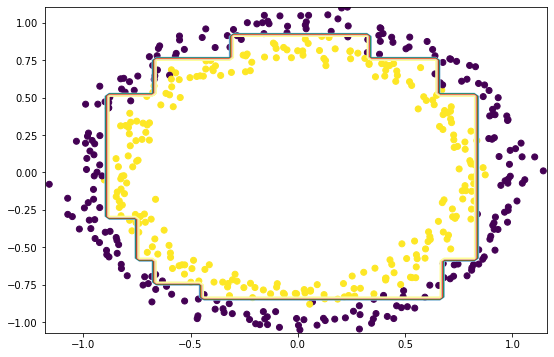

In [269]:
dt.plot(X, y) # 15

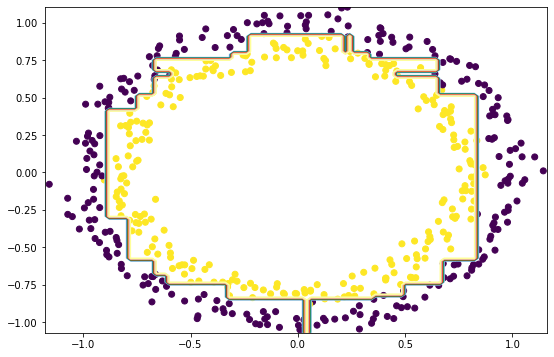

In [261]:
dt.plot(X, y) # 2